Total parameters in the 3D-MFS-Transformer model: 967599
Epoch 0, Iter 0, Loss 1.077165961265564
Epoch 0, Iter 10, Loss 0.9949414730072021
Epoch 0, Iter 20, Loss 0.9239863753318787
Epoch 0, Iter 30, Loss 0.9420279264450073
Epoch 0, Loss: 0.9548, Accuracy: 0.6617
Epoch 1, Iter 0, Loss 0.8847277760505676
Epoch 1, Iter 10, Loss 0.904711127281189
Epoch 1, Iter 20, Loss 0.838317334651947
Epoch 1, Iter 30, Loss 0.8448830842971802
Epoch 1, Loss: 0.8425, Accuracy: 0.6617
Epoch 2, Iter 0, Loss 0.7828549742698669
Epoch 2, Iter 10, Loss 0.781867265701294
Epoch 2, Iter 20, Loss 0.7564569115638733
Epoch 2, Iter 30, Loss 0.7492780089378357
Epoch 2, Loss: 0.7776, Accuracy: 0.6617
Epoch 3, Iter 0, Loss 0.7913214564323425
Epoch 3, Iter 10, Loss 0.716881513595581
Epoch 3, Iter 20, Loss 0.7185991406440735
Epoch 3, Iter 30, Loss 0.7422360777854919
Epoch 3, Loss: 0.7201, Accuracy: 0.6633
Epoch 4, Iter 0, Loss 0.6824927926063538
Epoch 4, Iter 10, Loss 0.6965532302856445
Epoch 4, Iter 20, Loss 0.691542804241

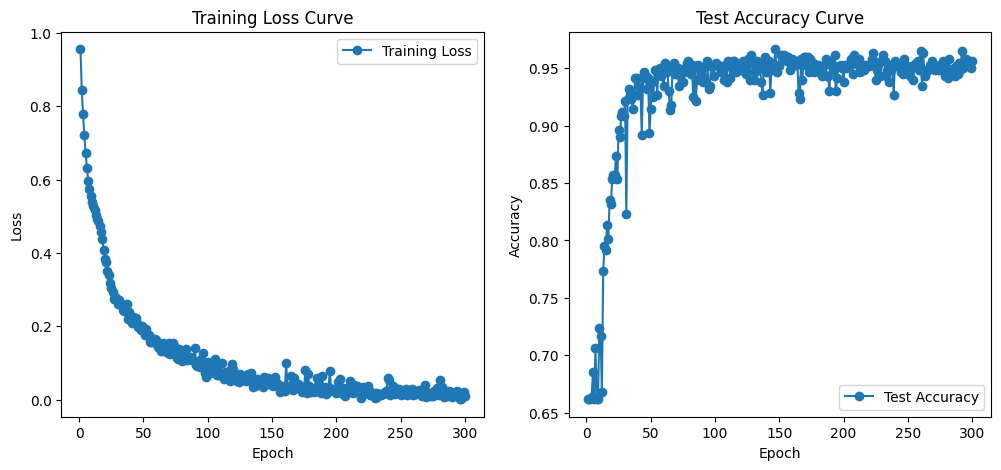

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import torch.optim as optim

class Scatter2MatrixConverter(nn.Module):
    def __init__(self, N_x=64):
        super(Scatter2MatrixConverter, self).__init__()
        self.N_x = N_x

    def process_4D(self, signal):
        B, C, H, W = signal.shape
        scatter2matrix_list = []

        for b in range(B):
            channel_matrices = []
            for c in range(C):
                scatter = signal[b, c]
                scatter = scatter.view(-1, scatter.shape[-1])
                scatter2matrix = self.convert(scatter)
                channel_matrices.append(scatter2matrix)
            scatter2matrix_list.append(torch.stack(channel_matrices))

        scatter2matrix_combine = torch.stack(scatter2matrix_list)
        return scatter2matrix_combine

    def convert(self, scatter):
        if scatter.shape[0] < scatter.shape[1]:
            scatter = scatter.T

        X = scatter.float()
        device = X.device
        X_min = torch.min(X) - 1e-10
        X_max = torch.max(X) + 1e-10
        i_x = torch.linspace(X_min, X_max, self.N_x + 1, device=device)
        ix = torch.bucketize(X, i_x) - 1
        ix = torch.clamp(ix, 0, self.N_x - 1)
        indices = torch.unbind(ix, dim=1)
        scatter2matrix = torch.zeros((self.N_x, self.N_x, self.N_x), dtype=torch.int64, device=device)
        scatter2matrix.index_put_(indices, torch.ones_like(ix[:, 0], dtype=torch.int64), accumulate=True)
        scatter2matrix = torch.nan_to_num(scatter2matrix, nan=0.0, posinf=0.0, neginf=0.0)
        return scatter2matrix

class QMSPF4DProcessor(nn.Module):
    def __init__(self, scale, q):
        super(QMSPF4DProcessor, self).__init__()
        self.scale = np.array(scale)
        self.q = q

    def process_5D(self, signal):
        B, C, X, Y, Z = signal.shape
        aq_min_values = []
        aq_max_values = []
        fa_all_signals = []
        aq_all_signals = []
        for b in range(B):
            fa_per_batch = []
            aq_per_batch = []
            for c in range(C):
                aq_b_c, fa_b_c, aq_min_b_c, aq_max_b_c = self._QMSPF3D(signal[b, c].cpu().detach().numpy())
                aq_min_values.append(aq_min_b_c)
                aq_max_values.append(aq_max_b_c)
                
                fa_per_batch.append(torch.tensor(fa_b_c, dtype=torch.float32))
                aq_per_batch.append(torch.tensor(aq_b_c, dtype=torch.float32))
            fa_all_signals.append(torch.stack(fa_per_batch))
            aq_all_signals.append(torch.stack(aq_per_batch))
        fa_all_signals = torch.stack(fa_all_signals)
        aq_all_signals = torch.stack(aq_all_signals)
        aq_min_values = torch.from_numpy(np.array(aq_min_values, dtype=np.float32)).view(B, C)
        aq_max_values = torch.from_numpy(np.array(aq_max_values, dtype=np.float32)).view(B, C)

        return aq_min_values, aq_max_values, aq_all_signals, fa_all_signals

    def _QMSPF3D(self, signal):
        total_sum = np.sum(signal)
        if total_sum == 0:
            total_sum = 1e-10
        X = signal / total_sum

        N1, N2, N3 = X.shape

        if np.min(self.scale) < 1:
            raise ValueError('The minimum scale must be larger than trend order 1')

        Fmean = []
        for s in self.scale:
            N1s = N1 // s
            N2s = N2 // s
            N3s = N3 // s

            X_reshaped = X[:N1s * s, :N2s * s, :N3s * s].reshape(N1s, s, N2s, s, N3s, s)
            Fmean_ns = np.sum(X_reshaped, axis=(1, 3, 5))
            Fmean.append(Fmean_ns)
        qRMS = []
        Fq = np.zeros((len(self.q), len(self.scale)))
        
        for ns, s in enumerate(self.scale):
            qqRMS_scale = Fmean[ns].flatten()
            qqRMS_scale = qqRMS_scale[qqRMS_scale > 2 ** -25]
            qRMS_ns = []
            for nq, q_val in enumerate(self.q):
                qRMS_nq_ns = qqRMS_scale ** q_val
                Fq[nq, ns] = np.sum(qRMS_nq_ns)
                qRMS_ns.append(qRMS_nq_ns)
            qRMS.append(qRMS_ns)

        tq = np.zeros(len(self.q))

        valid_indices = Fq > 0
        valid_points = np.sum(valid_indices, axis=1) > 1
        tq = np.empty(len(self.q))
        tq[~valid_points] = np.nan
        valid_indices = np.nonzero(valid_points)[0]

        if valid_indices.size == 0:
            log_Fq_valid = np.log2(Fq.T + 1e-10)
        else:
            log_scale = np.log2(self.scale)
            log_Fq_valid = np.log2(Fq[valid_indices].T + 1e-10)
            log_scale_broadcasted = np.log2(self.scale / N1)
            C = np.polyfit(log_scale_broadcasted, log_Fq_valid, 1)
            tq[valid_points] = C[0]

        aq = np.diff(tq) / (self.q[1] - self.q[0])
        fa = (self.q[:-1] * aq) - tq[:-1]
        aq_min = np.min(aq)
        aq_max = np.max(aq)

        return aq, fa, aq_min, aq_max
    
class GlobalMFSFilter2D(nn.Module):
    def __init__(self, C=32, X=100):
        super().__init__()
        self.C = C
        self.X = X
        self.weight = nn.Parameter(torch.ones(1, C, X, dtype=torch.float32))
        self.QMSPF3DProcessor = QMSPF4DProcessor(scale = np.array([8, 16, 32, 64]), q=np.linspace(-5, 5, 101))

    def forward(self, x):
        device = x.device
        aq_min_values, aq_max_values, aq, fa = self.QMSPF3DProcessor.process_5D(x)
        fa_all_signals = fa.to(device)
        aq_min_values = aq_min_values.to(device)
        aq_max_values = aq_max_values.to(device)
        B = fa_all_signals.size(0)
        if B > 1:
            weight = F.pad(self.weight, (0, 0, 0, 0, 0, B - 1))
        else:
            weight = self.weight
        fa_output = fa_all_signals * weight
        return aq, fa_output, aq_min_values, aq_max_values

class MFSNet(nn.Module):
    def __init__(self):
        super(MFSNet, self).__init__()
        self.Scatter2MatrixConverter = Scatter2MatrixConverter(N_x=64)
        self.filter = GlobalMFSFilter2D()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.embedding_dim = 32
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=self.embedding_dim, nhead=8)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=6)
        self.fc2 = nn.Linear(self.embedding_dim, 3)
        self.fc3 = nn.Linear(2, 100) 
        self._initialize_weights()
        self.bn1 = nn.BatchNorm1d(32)
        self.pool = nn.AdaptiveAvgPool1d(100)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        device = x.device

        x1 = x.squeeze(1).to(torch.float32).to(device)
        x1 = self.conv2(x1)
        x1 = self.bn1(x1)
        x1 = self.pool(x1)

        x = self.Scatter2MatrixConverter.process_4D(x)
        x = x.float().to(device)
        x = F.relu(self.conv1(x))

        aq, fa_output, aq_min_values, aq_max_values = self.filter(x)
        aq_min_values = aq_min_values.unsqueeze(-1).to(device)
        aq_max_values = aq_max_values.unsqueeze(-1).to(device)
        aq_means_combined = torch.cat((aq_min_values, aq_max_values), dim=-1).to(device)
        aq_means_combined = self.fc3(aq_means_combined).to(device)

        combine = x1 + fa_output + aq_means_combined
        combine = combine.permute(2, 0, 1)
        
        transformer_output = self.transformer(combine)
        pooled_output = torch.mean(transformer_output, dim=0)
        
        output = self.fc2(pooled_output)
        
        return aq, fa_output, output

BATCH_SIZE = 64

class ChaosDataset(Dataset):
    def __init__(self, datas, labels):
        self.datas = datas
        self.labels = labels

    def __len__(self):
        return len(self.datas)

    def __getitem__(self, idx):
        data = self.datas[idx]
        label = self.labels[idx]
        return data, label

allDatasArray = np.load(os.path.join("/home/sjtu/sjtu/HWY/allDatas_c3_dB0.npy"))
allLabelsArray = np.load(os.path.join("/home/sjtu/sjtu/HWY/allLabels_c3_dB0.npy"))
allDatasArray = allDatasArray[:, 1000:1128]

trainDatas, testDatas, trainLabels, testLabels = train_test_split(allDatasArray, allLabelsArray, test_size=0.2)
trainDatas = trainDatas.reshape(-1, 1, 128, 3)
testDatas = testDatas.reshape(-1, 1, 128, 3)
trainDataset = ChaosDataset(trainDatas, trainLabels)
testDataset = ChaosDataset(testDatas, testLabels)
trainLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=BATCH_SIZE, shuffle=False)

def count_parameters(model):
    total_params = 0
    for params in model.parameters():
        total_params += params.numel()
    return total_params

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = MFSNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

total_params = count_parameters(model)
print(f"Total parameters in the 3D-MFS-Transformer model: {total_params}")
EPOCHS = 300

train_losses = []
test_accuracies = []
best_accuracy = 0.0 

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for i, (datas, labels) in enumerate(trainLoader):
        datas, labels = datas.to(device), labels.to(device)
        

        optimizer.zero_grad()
        aq, fa_output, outputs = model(datas.permute(0, 1, 3, 2))
        loss = criterion(outputs, labels.long())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 10 == 0:
            print(f"Epoch {epoch}, Iter {i}, Loss {loss.item()}")
    
    average_loss = running_loss / len(trainLoader)
    train_losses.append(average_loss)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for datas, labels in testLoader:
            datas, labels = datas.to(device), labels.to(device)
            aq, fa_output, outputs = model(datas.permute(0, 1, 3, 2))
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        accuracy = correct / total
        test_accuracies.append(accuracy)
        print(f"Epoch {epoch}, Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")

with open('train_test_metrics.pkl', 'wb') as f:
    pickle.dump({'train_losses': train_losses, 'test_accuracies': test_accuracies}, f)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS + 1), test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Curve')
plt.legend()
plt.show()